# Predicting the Round of a Jeopardy! Question using Logistic Regression

In this notebook, we aim to build a classification model that takes a Jeopardy! question as input and predicts the round for which the question was posed. Round is used as a proxy for question difficulty.

In [4]:
import torch
import torchtext
import torchdata
import portalocker
import json
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [5]:
# Function to ensure the correct versions are installed.
def check_lib_versions():
    libversions = {torch: "2.0",  torchtext: "0.15.1", torchdata: "0.6.0",
                   portalocker: "2.7.0"}
    for l, v in libversions.items():
        try:
            assert l.__version__ == v
        except:
            name = [n for n in globals() if globals()[n] is l][0]
            print(f'Error: The version of {name} should be {v}.')
check_lib_versions()

In [6]:
filename = 'jeopardy_json.json'

with open(filename, 'r', encoding='iso-8859-1') as f:
    data = json.load(f)

data

[{'category': 'HISTORY',
  'air_date': '2004-12-31',
  'question': "'For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory'",
  'value': '$200',
  'answer': 'Copernicus',
  'round': 'Jeopardy!',
  'show_number': '4680'},
 {'category': "ESPN's TOP 10 ALL-TIME ATHLETES",
  'air_date': '2004-12-31',
  'question': "'No. 2: 1912 Olympian; football star at Carlisle Indian School; 6 MLB seasons with the Reds, Giants & Braves'",
  'value': '$200',
  'answer': 'Jim Thorpe',
  'round': 'Jeopardy!',
  'show_number': '4680'},
 {'category': 'EVERYBODY TALKS ABOUT IT...',
  'air_date': '2004-12-31',
  'question': "'The city of Yuma in this state has a record average of 4,055 hours of sunshine each year'",
  'value': '$200',
  'answer': 'Arizona',
  'round': 'Jeopardy!',
  'show_number': '4680'},
 {'category': 'THE COMPANY LINE',
  'air_date': '2004-12-31',
  'question': '\'In 1963, live on "The Art Linkletter Show", this company served its billionth burger\

Round lables:
0 - Jeopardy!
1 - Double Jeopardy!
2 - Final Jeopardy!
3 - Tiebreaker

In [7]:
examples_rounds = []
examples_categories = []
examples_values = []

def create_label_text_pairs(data):
    for row in data:
        if row['round'] == 'Jeopardy!':
            round_label = 1
        elif row['round'] == 'Double Jeopardy!':
            round_label = 2
        elif row['round'] == 'Final Jeopardy!':
            round_label = 3
        elif row['round'] == 'Tiebreaker':
            round_label = 4
        row_qn = row['question'].replace("'", "")
        examples_rounds.append((round_label, row_qn))
        examples_categories.append((row['category'], row_qn))
        examples_values.append((row['value'], row_qn))
    return examples_rounds, examples_categories, examples_values

examples_rounds, examples_categories, examples_values = create_label_text_pairs(data)

len(examples_rounds)
examples_rounds[0]

(1,
 'For the last 8 years of his life, Galileo was under house arrest for espousing this mans theory')

In [8]:
def get_text(pairs):
    '''
    From each label-text pair, extract the text
    and compile into a string to feed into the vocabulary.
    '''
    text = list(map(lambda x: x[1], pairs))
    res = ' '.join(text)
    return res

t = get_text(examples_rounds)

In [9]:
class JeopardyData(Dataset):
    def __init__(self, examples=list, vocabulary = None):
        '''
        Create a dataset of examples (list of tuples), with each example being
        a tuple (label, text)
        '''
        self.examples = examples
        self.text = get_text(examples)
        if not vocabulary:
            self.vocab = build_vocab_from_iterator(
                map(get_tokenizer('basic_english'), self.text),
                specials=['<unk>'])
            self.vocab.set_default_index(self.vocab['<unk>'])
        else:
            self.vocab = vocabulary
    
    @property
    def vocab_size(self):
        # add one more for out of vocab words
        return len(self.vocab) + 1
    
    def get_vocab(self):
        return self.vocab

In [10]:
rounds_data = JeopardyData(examples_rounds)

In [11]:
# focusing on rounds, create vocab for rounds only
vocab = rounds_data.get_vocab()

In [12]:
from torch.utils.data import DataLoader

tokenizer = get_tokenizer('basic_english')

def collate_into_bow(batch):
    labels = []
    bow_vectors = []
    for label, text in batch:
        labels.append(label-1)
        bow_vector = [0.0] * len(vocab)
        tokens = tokenizer(text)
        for t in tokens:
            t_idx = vocab[t]
            bow_vector[t_idx] += 1
        bow_vector = [x / len(tokens) for x in bow_vector]
        bow_vectors.append(bow_vector)
    result = (torch.tensor(labels), torch.tensor(bow_vectors))

    return result


def test_collate():
    w1 = vocab.lookup_token(3)
    w2 = vocab.lookup_token(7)
    w3 = vocab.lookup_token(8)
    w4 = vocab.lookup_token(9)
    examples = [
        (1, " ".join([w1, w2, w3, w4])),
        (2, " ".join([w2, w1, w3, w4])),
        (4, " ".join([w4, w2, w3, w4])),
        (3, " ".join([w2, w2, w2, w4])),
        (3, " ".join([w1, w2])),

    ]
    bowt = torch.tensor(
        [
            [0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.25, 0.25, 0.25],
            [0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.25, 0.25, 0.25],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.25, 0.50],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.75, 0.0, 0.25],
            [0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.5, 0.0, 0.00],

        ]) 
    lt, tt = collate_into_bow(examples)
    assert lt.shape == torch.Size([5])
    assert tt.shape == torch.Size([5, len(vocab)])
    # print(lt, tt)
    assert torch.equal(lt, torch.tensor([0, 1, 3, 2, 2]))
    assert torch.equal(tt[:,:10], bowt)
    assert tt[:,10:].sum().item() == 0.00
    print('Test passed.')
    
test_collate()

Test passed.


### BOW Classifier

In [13]:
from torch import nn
import torch.nn.functional as F

class BoWClassifier(nn.Module):
    def __init__(self, num_labels, vocab_size):
        super(BoWClassifier, self).__init__()
        self.linear = nn.Linear(vocab_size, num_labels)
    
    def forward(self, bow_vec):
        return F.log_softmax(self.linear(bow_vec), dim=1)

### Create function to train one epoch

In [14]:
import time

loss_function = torch.nn.NLLLoss()

def train_an_epoch(dataloader, optimizer):
    model.train() # Sets the module in training mode.
    log_interval = 500

    for idx, (label, text) in enumerate(dataloader):
        model.zero_grad()
        log_probs = model(text) # forward pass
        loss = loss_function(log_probs, label)
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')

### Create function to compute accuracy

In [15]:
def get_accuracy(dataloader):
    model.eval() # switch to indicate that the model is not in training mode
    with torch.no_grad(): # disables gradient calculation (for when you are sure you will not call Tensor.backward()). This will reduce memory consumption.
        total_examples = 0
        correct = 0
        for labels, text in dataloader: # for each batch in dataloader
            total_examples += text.shape[0]
            probs = model(text)
            preds = probs.argmax(1)
            correct += (torch.eq(preds, labels)).sum().item()
        overall_accuracy = correct / total_examples
        return overall_accuracy


In [16]:
from torch.utils.data.dataset import random_split

train_size = int(0.8*len(data))
val_size = int(0.1*len(data))
test_size = int(0.1*len(data))

BATCH_SIZE = 64

train_data, valid_data, test_data = random_split(rounds_data.examples, [0.8, 0.1, 0.1])

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_into_bow)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_into_bow)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_into_bow)

In [17]:
num_labels = len(set([label for (label, text) in train_data]))
vocab_size = len(vocab)
model = BoWClassifier(num_labels, vocab_size)

### Training

At iteration 500 the loss is 0.893.
At iteration 1000 the loss is 1.045.
At iteration 1500 the loss is 1.255.
At iteration 2000 the loss is 0.805.
At iteration 2500 the loss is 1.493.

After epoch 1 the validation accuracy is 0.486.

At iteration 500 the loss is 1.765.
At iteration 1000 the loss is 0.983.
At iteration 1500 the loss is 1.954.
At iteration 2000 the loss is 1.136.
At iteration 2500 the loss is 1.174.

After epoch 2 the validation accuracy is 0.486.

At iteration 500 the loss is 1.505.
At iteration 1000 the loss is 1.513.
At iteration 1500 the loss is 0.846.
At iteration 2000 the loss is 1.619.
At iteration 2500 the loss is 0.751.

After epoch 3 the validation accuracy is 0.496.

At iteration 500 the loss is 0.914.
At iteration 1000 the loss is 1.414.
At iteration 1500 the loss is 0.848.
At iteration 2000 the loss is 0.958.
At iteration 2500 the loss is 0.936.

After epoch 4 the validation accuracy is 0.497.

At iteration 500 the loss is 1.263.
At iteration 1000 the loss i

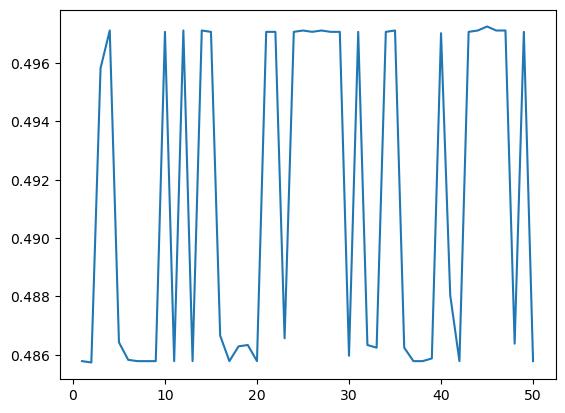

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

EPOCHS = 50 # epoch
optimizer = torch.optim.SGD(model.parameters(), lr=3)

accuracies=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer)
    accuracy = get_accuracy(valid_dataloader)
    accuracies.append(accuracy)
    time_taken = time.time() - epoch_start_time
    print()
    print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}.')
    print()
    
plt.plot(range(1, EPOCHS+1), accuracies)

In [19]:
test_accuracy = get_accuracy(test_dataloader)
print("test accuracy from model trained on 50 epochs:", test_accuracy)

test accuracy from model trained on 50 epochs: 0.49084958281473284


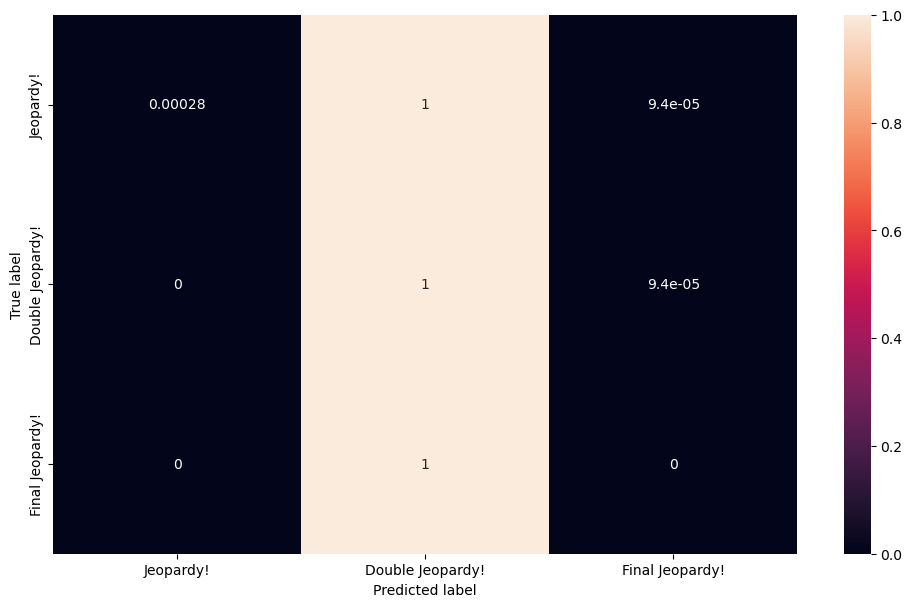

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np

y_pred = []
y_true = []

# iterate over test data
for labels, inputs in test_dataloader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes (only three because there were no instances of Tiebreaker in the test data)
classes = ('Jeopardy!', 'Double Jeopardy!', 'Final Jeopardy!')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('output.png')

## Examining the dataset

In [ ]:
df = pd.DataFrame(data)
df

,category,air_date,question,value,answer,round,show_number
0,HISTORY,2004-12-31,"'For the last 8 years of his life, Galileo was...",$200,Copernicus,Jeopardy!,4680
1,ESPN's TOP 10 ALL-TIME ATHLETES,2004-12-31,'No. 2: 1912 Olympian; football star at Carlis...,$200,Jim Thorpe,Jeopardy!,4680
2,EVERYBODY TALKS ABOUT IT...,2004-12-31,'The city of Yuma in this state has a record a...,$200,Arizona,Jeopardy!,4680
3,THE COMPANY LINE,2004-12-31,"'In 1963, live on ""The Art Linkletter Show"", t...",$200,McDonald\'s,Jeopardy!,4680
4,EPITAPHS & TRIBUTES,2004-12-31,"'Signer of the Dec. of Indep., framer of the C...",$200,John Adams,Jeopardy!,4680
...,...,...,...,...,...,...,...
216925,RIDDLE ME THIS,2006-05-11,'This Puccini opera turns on the solution to 3...,$2000,Turandot,Double Jeopardy!,4999
216926,"""T"" BIRDS",2006-05-11,'In North America this term is properly applie...,$2000,a titmouse,Double Jeopardy!,4999
216927,AUTHORS IN THEIR YOUTH,2006-05-11,"'In Penny Lane, where this ""Hellraiser"" grew u...",$2000,Clive Barker,Double Jeopardy!,4999
216928,QUOTATIONS,2006-05-11,"'From Ft. Sill, Okla. he made the plea, Arizon...",$2000,Geronimo,Double Jeopardy!,4999


In [ ]:
df['round'].value_counts()

round
Jeopardy!           107384
Double Jeopardy!    105912
Final Jeopardy!       3631
Tiebreaker               3
Name: count, dtype: int64

There is balance in the number of examples for Jeopardy! and Double Jeopardy! rounds, but far fewer examples of the Final Jeopardy! and Tiebreaker! rounds. Excluding Tiebreaker from our discussion, if the dataset were balanced across the three rounds and the model did not learn anything from the examples, its accuracy would be about 33%. In this case, the higher accuracy may be attributed to the data being heavily skewed towards Jeopardy! and Double Jeopardy!, suggesting that the model may be predicting one of the two randomly.